# XGBoost

## Read data

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from electricity_price_forecast.eval import get_test_metrics
from electricity_price_forecast.data.data_visualization import plot_prices, plot_predictions_vs_real
from electricity_price_forecast.data.data_processing import preprocess_true_data, preprocess_synthetic_data


from typing import List

df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

In [2]:
df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet")
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

print(df_price.index.min())
print(df_price.index.max())
df_price.head()

2016-12-31 23:00:00+00:00
2020-12-31 22:00:00+00:00


,price
date,
2016-12-31 23:00:00+00:00,58.82
2017-01-01 00:00:00+00:00,58.23
2017-01-01 01:00:00+00:00,51.95
2017-01-01 02:00:00+00:00,47.27
2017-01-01 03:00:00+00:00,45.49


In [3]:
print(df_price_generated_00257["dayofweek"].min())
print(df_price_generated_00257["dayofweek"].max())
df_price_generated_00257.head()

0
6


,price,dayofweek,hourofday
0,31.66,0,0
1,31.06,0,1
2,27.81,0,2
3,27.54,0,3
4,25.04,0,4


## Preprocess data

In [4]:
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head()

,price,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year
date,,,,,,,,
2016-12-31 23:00:00+00:00,58.82,5,23,366,0,31,12,2016
2017-01-01 00:00:00+00:00,58.23,6,0,1,1,1,1,2017
2017-01-01 01:00:00+00:00,51.95,6,1,1,1,1,1,2017
2017-01-01 02:00:00+00:00,47.27,6,2,1,1,1,1,2017
2017-01-01 03:00:00+00:00,45.49,6,3,1,1,1,1,2017


In [5]:
df_price_generated_00257_preprocessed = preprocess_synthetic_data(df_price_generated_00257)
df_price_generated_00257_preprocessed.head()

,price,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year
date,,,,,,,,
2016-12-31 00:00:00+00:00,31.66,5,0,366,0,31,12,2016
2016-12-31 01:00:00+00:00,31.06,5,1,366,0,31,12,2016
2016-12-31 02:00:00+00:00,27.81,5,2,366,0,31,12,2016
2016-12-31 03:00:00+00:00,27.54,5,3,366,0,31,12,2016
2016-12-31 04:00:00+00:00,25.04,5,4,366,0,31,12,2016


## Plot data

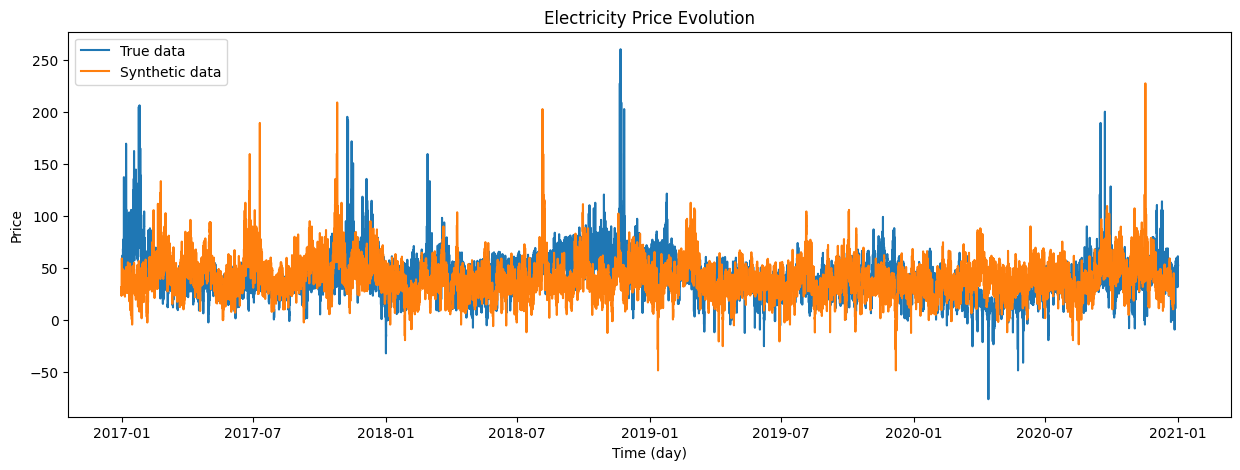

In [6]:
plot_prices([df_price_preprocessed, df_price_generated_00257_preprocessed], ["True data", "Synthetic data"])

## Feature Engineering

One example x is `[dayofweek, hourofday, dayofseries]` or another set of attributes and y is `price`

In [7]:
def get_x_y_point_by_point(df, x_keys: List[str], y_key: str):
    X = df[x_keys]
    y = df[y_key]
    return X, y

One example x is a sequence of values of one attribute (e.g. x is `dayofseries_1, dayofseries_2, ..., dayofseries_5`) using a window and y is `price`

In [8]:
def get_x_y_window(df, y_key: str, window_size: int, window_step: int, horizon: int):
    X, y  = [], []

    for i in range(0, len(df[y_key]) - window_size - horizon, window_step):
        X.append(df[y_key][i:i+window_size])
        y.append(df[y_key][i+window_size:i+window_size+horizon])
        
    return X, y

## Train & Test Splits

In [9]:
def split_data(df, horizon):
    train_df = df[:-horizon]
    test_df = df[-horizon:]
    return train_df, test_df

## Training functions

In [10]:
def get_best_params(X_train, y_train):
    xgb_model = xgb.XGBRegressor()
    reg_cv = GridSearchCV(xgb_model, {'max_depth': [1,5,10], 'n_estimators': [50, 200, 500], 'learning_rate': [0.001, 0.01, 0.1]}, verbose=1)
    reg_cv.fit(X_train, y_train)
    return reg_cv.best_params_

def train_model(X_train, y_train, params=None):
    if params is None:
        xgb_model = xgb.XGBRegressor()
    else:
        xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train,y_train)
    
    return xgb_model

## Point by point

### Without data augmentation

#### Search hyper params

In [11]:
train_data, test_data = split_data(df_price_preprocessed, 24)
X_train, y_train = get_x_y_point_by_point(train_data, ["dayofweek", "hourofday", "dayofseries"], "price")
X_test, y_test = get_x_y_point_by_point(test_data, ["dayofweek", "hourofday", "dayofseries"], "price")

# params = get_best_params(X_train, y_train)
params = {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}

#### Train and eval

In [12]:
xgb_model = train_model(X_train, y_train, params)

Results: {'MAE': 12.753098719914753, 'MSE': 173.9422342313458, 'RMSE': 13.188716170702355}
0 24 24


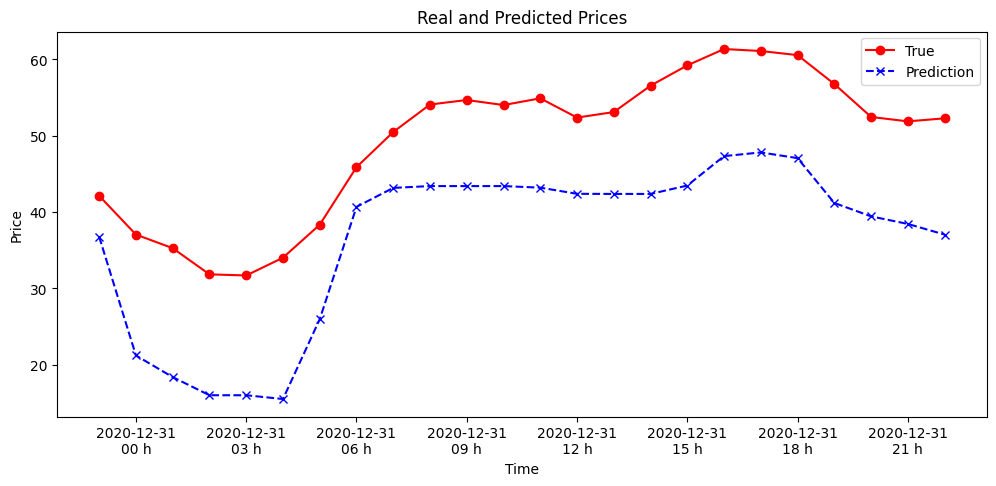

In [13]:
predictions = xgb_model.predict(X_test)

results = get_test_metrics(predictions, y_test)

print("Results:", results)
plot_predictions_vs_real(X_test["date"].values, y_test, predictions)

### With provided data augmentation (synthetic data)

In [14]:
def load_synthetic_data_point_by_point(path, max_files=None):
    X_train_all, y_train_all = [], []
    
    i = 0
    for filename in tqdm(os.listdir(path)):
        if max_files is not None and i >= max_files:
            break
        i += 1
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            X_train, y_train = get_x_y_point_by_point(df_preprocessed, ["dayofweek", "hourofday", "dayofseries"], "price")
            
            X_train_all.append(X_train)
            y_train_all.append(y_train)
    
    X_train_all = pd.concat(X_train_all)
    y_train_all = pd.concat(y_train_all)

    return X_train_all, y_train_all

In [15]:
directory = "../data/scenarios synthetiques/prix/"
X_train_synthetic, y_train_synthetic = load_synthetic_data_point_by_point(directory, 10)
X_train_all = pd.concat([X_train, X_train_synthetic])
y_train_all = pd.concat([y_train, y_train_synthetic])

  6%|▋         | 10/154 [00:00<00:02, 69.68it/s]


In [16]:
xgb_model = train_model(X_train_synthetic, y_train_synthetic, params)

Results: {'MAE': 8.64115866025289, 'MSE': 103.6059368072966, 'RMSE': 10.178700153128425}
0 24 24


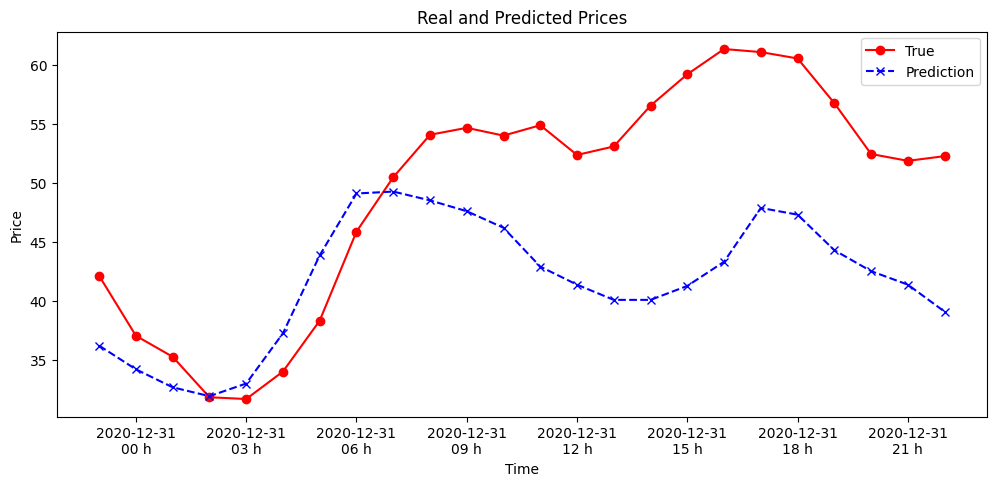

In [17]:
predictions = xgb_model.predict(X_test)
results = get_test_metrics(predictions, y_test)
print("Results:", results)
plot_predictions_vs_real(X_test["date"].values, y_test, predictions)

## Window

### Without data augmentation



In [11]:
params = {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}

In [20]:
train_data, test_data = split_data(df_price_preprocessed, 24+12+12)
X_train, y_train = get_x_y_window(train_data, "price", 24, 12, 12)
X_test, y_test = get_x_y_window(test_data, "price", 24, 12, 12)
# params = get_best_params(X_train, y_train)

#### Train and eval

In [21]:
xgb_model = train_model(X_train, y_train, params)

Results: {'MAE': 9.093372629117717, 'MSE': 174.9450084239535, 'RMSE': 13.226677905806639}
0 12 12


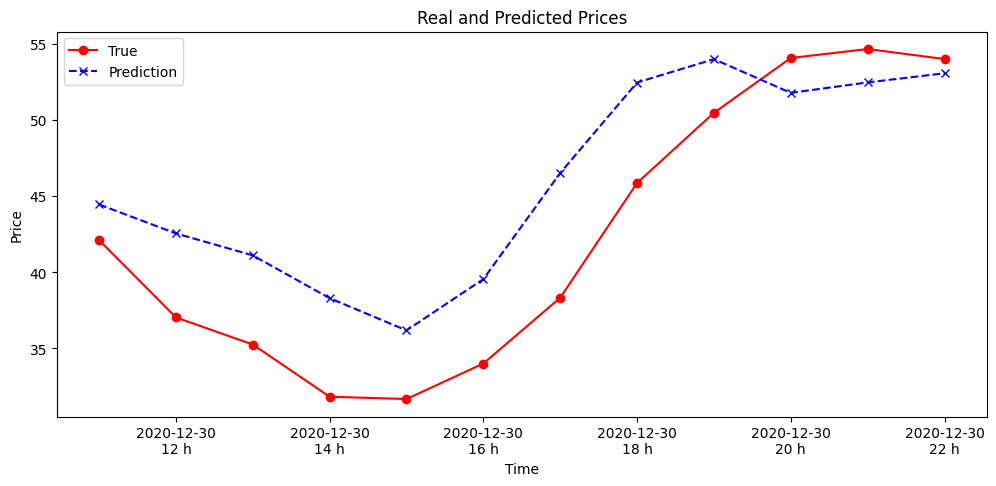

In [29]:
predictions = xgb_model.predict(X_test)
print("Results:", results)
plot_predictions_vs_real(X_test[0][12:]["date"].values, y_test[0], predictions[0])

### With provided data augmentation (synthetic data)

In [30]:
def load_synthetic_data_window(path, max_files=None):
    X_train_all, y_train_all = [], []
    i = 0
    for filename in tqdm(os.listdir(path)):
        if max_files is not None and i >= max_files:
            break
        i += 1
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            
            X_train, y_train = get_x_y_window(df_preprocessed, "price", 24, 12, 12)
            
            X_train_all.extend(X_train)
            y_train_all.extend(y_train)

    return X_train_all, y_train_all

In [31]:
directory = "../data/scenarios synthetiques/prix/"
X_train_synthetic, y_train_synthetic = load_synthetic_data_window(directory)
X_train_all = X_train + X_train_synthetic
y_train_all = y_train + y_train_synthetic

100%|██████████| 154/154 [00:34<00:00,  4.51it/s]


In [32]:
xgb_model = train_model(X_train_synthetic, y_train_synthetic, params)

Results: {'MAE': 9.093372629117717, 'MSE': 174.9450084239535, 'RMSE': 13.226677905806639}
0 12 12


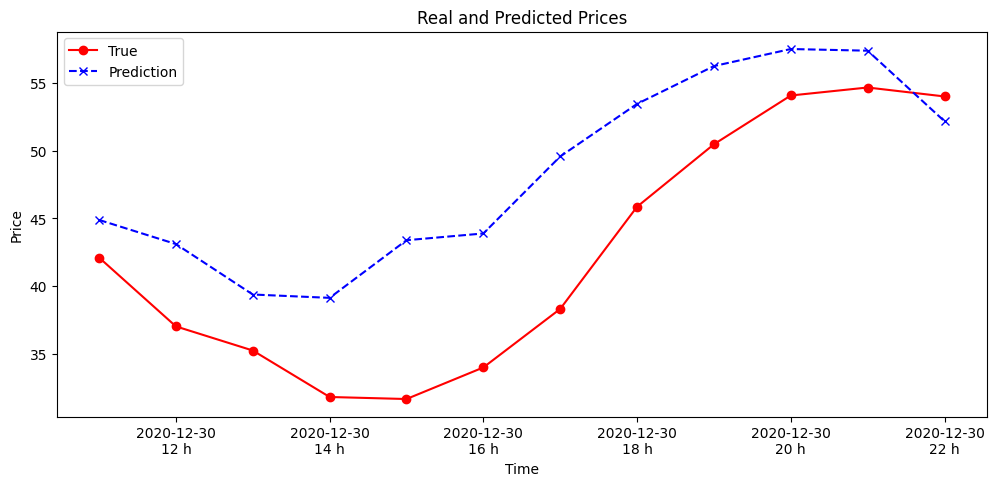

In [33]:
predictions = xgb_model.predict(X_test)
print("Results:", results)
plot_predictions_vs_real(X_test[0][12:]["date"].values, y_test[0], predictions[0])